# PHY480/905 Semester Project 

#### PHY 480/905 Semester Project
### &#9989; Jonathan Kho

#### &#9989; Last Updated on WHAT DATE

# Modeling advection in 1D


##  Introduction 

_(Provide context for the problem: Background and Motivation.  **Clearly state the question(s) you set
out to answer.**)_

## Methodology

_(How did you go about answering your question(s)? Most of your code will be
contained in this section.)_

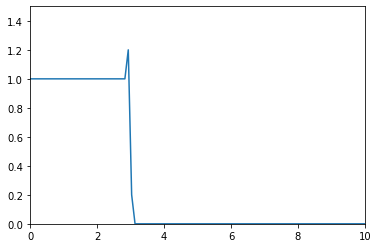

In [2]:
# Naive method
# Credit to: https://www.ita.uni-heidelberg.de/~dullemond/lectures/studtage_compastro_2018/index.shtml?lang=en

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

nx   = 100
nt   = 100
x    = np.linspace(0.,10.,nx)
t    = np.linspace(0.,10.,nt)
q    = np.zeros((nt,nx))
q[0,x<3] = 1.0     # Step function initial condition
v0   = 0.4         # Constant fluid velocity

for n in range(0,nt-1):
    dt          = t[n+1] - t[n]
    q[n+1,1:-1] = q[n,1:-1] - dt * v0 * ( q[n,2:] - q[n,:-2] ) / ( x[2:] - x[:-2] )
    q[n+1,0]    = q[n,0]
    q[n+1,-1]   = q[n,-1]

n = 0
def animupdate(frameNum, a0):
    global n,q,x,nt
    y = q[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [])
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('naiveadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

In [22]:
# Creating a basic grid:

class grid():
    
    def __init__(self,xsize,tmax):
        
        self.vals = np.zeros((tmax,xsize))
        
    def initialize(self,vals):
    
        self.vals[0,:] = vals
    
    def get_vals(self):
        
        return(self.vals)
    
    def update(self,loc,new_vals):
        
        self.vals[loc] = new_vals
        
        
# Creating my simple advection function using the upwind method:

def solve_adv(vals, C = 0.1,v0 = 1,tfactor = 1):
    
    xsize = len(vals)
    dx = (1/xsize) # Taking even step sizes dx
    dt = C*dx/v0 # Calculating our dt steps from our C value
    tmax = tfactor*xsize/v0
    tlength = int(tmax/dt)
    
    board = grid(xsize,tlength)
    board.initialize(abs(vals)) # Ensuring all positive values
        
    for t in range(tlength-1):
        
        vals = board.get_vals()
        
        for i in range(xsize):
            
            if v0 > 0: # Our updated values will change depending on which way our fluid is flowing
                # The modulus here is to be careful not to index past the size of our board:
                updated_val = vals[t,i] - C * ( vals[t,i] - vals[t,(i+1)%xsize] ) 
                board.update((t+1,i),updated_val) 
                
            elif v0 < 0:
                # If our fluid is flowing backwards, we want to check the difference with our i-1 cell
                updated_val = vals[t,i] - C * ( vals[t,i] - vals[t,i-1] )
                board.update((t+1,i),updated_val) 

    return(board)

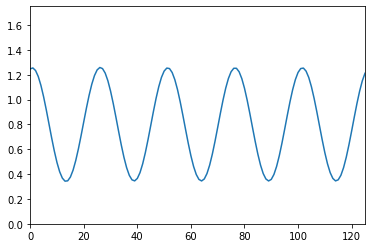

In [50]:
x = np.arange(0,2*np.pi,0.05)
y = 0.8 + 0.8*np.sin(5*x)

board = solve_adv(y,v0 = -10,tfactor = 1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

def animupdate(frameNum, a0):
    global n,vals,x,nt
    y = vals[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.75))
a0, = ax.plot([], [])
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('forwardadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

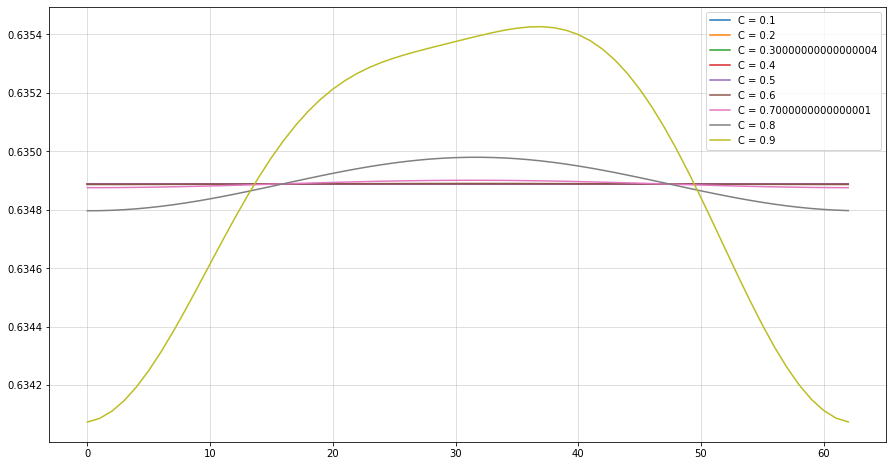

In [51]:
# Testing C parameter for stability:

x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)

Cs = np.arange(0.1,1,0.1)

solns = []

for i in range(len(Cs)):
    soln = solve_adv(vals = y,C = Cs[i])
    solns.append(soln.get_vals()[-1,:])
    
x = np.arange(len(solns[0]))
plt.figure(figsize = (15,8))
for i in range(len(solns)):
    plt.plot(x,solns[i],label = 'C = {}'.format(Cs[i]))
    
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig('C_variations_upwind')

In [55]:
# Implementing pressure and different molecular weight

def advanced_adv(vals, C = 0.1,v0 = 100,tfactor = 1,mu = 1): 
    
    xsize = len(vals)
    dx = (1/xsize) # Taking even step sizes dx
    dt = C*dx/v0 # Calculating our dt steps from our C value
    tmax = tfactor*xsize/v0
    tlength = int(tmax/dt)
    
    # kB = 1.38e-23 # Boltzmann's constant
    # mp = 1.67e-27 # Proton mass
    # cs2 = kB*T/(mu*mp) Actual sound crossing speed, but only interested in mu scalings
    cs2 = 1/mu # Sound-crossing speed squared, relevant for pressure term
    
    board = grid(xsize,tlength)
    board.initialize(abs(vals)) # Ensuring all positive values
        
    for t in range(tlength-1):
        
        vals = board.get_vals()
            
        for i in range(xsize):
            
            if v0 > 0: # Our updated values will change depending on which way our fluid is flowing
                # The modulus here is to be careful not to index past the size of our board:
                updated_val = vals[t,i] - C * (cs2 + v0**2)/v0**2 * ( vals[t,i] - vals[t,(i+1)%xsize] ) 
                board.update((t+1,i),updated_val) 
                
            elif v0 < 0:
                # If our fluid is flowing backwards, we want to check the difference with our i-1 cell
                updated_val = vals[t,i] - C * (cs2 + v0**2)/v0**2 * ( vals[t,i] - vals[t,i-1] )
                board.update((t+1,i),updated_val)

    return(board)

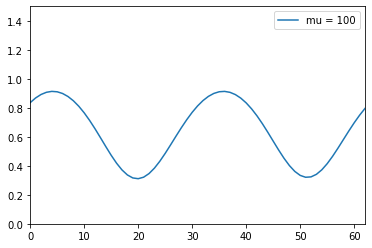

In [69]:
x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)
mu1 = 100

board = advanced_adv(y,v0 = -10,mu = mu1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [],label = 'mu = {}'.format(mu1))
plt.legend()
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('muadvection5.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

## Results and Discussion

_(What did you find when you carried out your methods? Some of your code related to presenting results/figures/data may be replicated from the methods section or may only be present in
this section.
All of the plots that you plan on using for your presentation should be present in this section)_

##  Conclusion and Perspectives

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   
Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. 
**Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

1. https://www.ita.uni-heidelberg.de/~dullemond/lectures/studtage_compastro_2018/index.shtml?lang=en
2. https://github.com/python-hydro/hydro_examples
3. http://bender.astro.sunysb.edu/hydro_by_example/CompHydroTutorial.pdf

##  Appendices
